In [7]:
# Import machine learning packages for ease
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.feature_selection import VarianceThreshold, RFE, SequentialFeatureSelector
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from scipy.spatial import distance, distance_matrix
from difflib import SequenceMatcher
import warnings
import time
from tqdm import tqdm

In [2]:
# Suppress warnings that are typically produced during automated ML tasks
warnings.filterwarnings('ignore')

In [3]:
# Load the state-wise accident dataset
US_dataset = pd.read_csv('accidents.csv', sep=',')
print(US_dataset.head)

# Extract the column names and present them
US_names = US_dataset.columns.to_list()
print(US_names)

# Show number of NaNs
print(f'# NaNs before drop: {US_dataset.isna().sum().sum()}')

# Interpolate to rid of NaNs
US_dataset = US_dataset.dropna()

# Show number of NaNs
print(f'# NaNs after drop: {US_dataset.isna().sum().sum()}')

<bound method NDFrame.head of                 ID   Source  Severity           Start_Time  \
0              A-1  Source2         3  2016-02-08 05:46:00   
1              A-2  Source2         2  2016-02-08 06:07:59   
2              A-3  Source2         2  2016-02-08 06:49:27   
3              A-4  Source2         3  2016-02-08 07:23:34   
4              A-5  Source2         2  2016-02-08 07:39:07   
...            ...      ...       ...                  ...   
7728389  A-7777757  Source1         2  2019-08-23 18:03:25   
7728390  A-7777758  Source1         2  2019-08-23 19:11:30   
7728391  A-7777759  Source1         2  2019-08-23 19:00:21   
7728392  A-7777760  Source1         2  2019-08-23 19:00:21   
7728393  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Start_Lat   Start_Lng   End_Lat    End_Lng  \
0        2016-02-08 11:00:00  39.865147  -84.058723       NaN        NaN   
1        2016-02-08 06:37:59  39.928059  -82.831184       NaN        NaN 

In [4]:
# Splits of dataset by State
splits = US_dataset.groupby('State')

# Create dictionary of dataframes for states
US_States_datasets = {k: v for k, v in splits}

# Present states and their data shapes
for k, v in US_States_datasets.items():
    print(f'{k}: {v.shape}')

AL: (26786, 46)
AR: (18629, 46)
AZ: (73067, 46)
CA: (880453, 46)
CO: (36258, 46)
CT: (41343, 46)
DC: (13544, 46)
DE: (6596, 46)
FL: (529393, 46)
GA: (53580, 46)
IA: (11920, 46)
ID: (8884, 46)
IL: (42194, 46)
IN: (23553, 46)
KS: (11551, 46)
KY: (4685, 46)
LA: (68749, 46)
MA: (5267, 46)
MD: (66544, 46)
ME: (989, 46)
MI: (55275, 46)
MN: (116608, 46)
MO: (32006, 46)
MS: (6990, 46)
MT: (26293, 46)
NC: (132011, 46)
ND: (2705, 46)
NE: (3406, 46)
NH: (1840, 46)
NJ: (72341, 46)
NM: (2495, 46)
NV: (7762, 46)
NY: (168004, 46)
OH: (32050, 46)
OK: (11294, 46)
OR: (125802, 46)
PA: (161697, 46)
RI: (2817, 46)
SC: (136485, 46)
SD: (196, 46)
TN: (74679, 46)
TX: (178750, 46)
UT: (45625, 46)
VA: (176331, 46)
VT: (220, 46)
WA: (31598, 46)
WI: (11703, 46)
WV: (11160, 46)
WY: (2421, 46)


In [5]:
# Clean up state datasets
for US_State_name, US_State_dataset in tqdm(US_States_datasets.items()):

    # Removes state column since completely unecessary now
    US_State_dataset.drop(columns=['State'])

    # Performs encoding to remove string-type data
    for col in US_State_dataset.columns:
        if US_State_dataset[col].dtype == 'object':
            le = LabelEncoder()
            le.fit(US_State_dataset[col])
            US_State_dataset[col] = le.transform(US_State_dataset[col])

    # To stick with budget on time for assignment, reduce any datasets with over 5000 samples to 5000 samples
    if US_State_dataset.shape[0] > 5000:
        US_States_datasets[US_State_name] = resample(US_State_dataset, n_samples=5000)

100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


# EXPERIMENT

- [ ] For each feature selection method
  - [x] Time for computation?
  - [ ] What level of variance was there between each state in terms of features selected?
  - [x] Calculate the mean performance after fitting and cross validating on a choice ML algorithm for each US state subdataset (see **'$'** below)
- [x] For each US State subdataset in feature selection method
  - [x] What top 10 features were selection?
    - [x] Is there an order to them?
  - [x] **$** Using selected features, fit and cross validate on a choice ML algorithm
    - [x] What was the performance?

## How to measure distance or variance between lists

1. Combine all lists into a 2D array  
**data = np.array([list1, list2, list3])**

2. Calculate the pairwise Euclidean distance between lists  
**distances = distance.pdist(data, 'hamming')**

3. Convert the pairwise distances into a matrix  
**matrix = distance_matrix(data, data)**

4. Calculate the average distance between lists  
**average_distance = np.mean(matrix)**

5. Print results  
**print("Average distance:", average_distance)**

AL: ['ID', 'Source', 'Distance(mi)', 'State', 'Country', 'Bump', 'Give_Way', 'No_Exit', 'Roundabout', 'Traffic_Calming'] -- score: 0.9361999148789689
AR: ['ID', 'Source', 'Start_Time', 'End_Lat', 'County', 'State', 'Country', 'Timezone', 'Bump', 'Give_Way'] -- score: 0.7346306248954292
AZ: ['Source', 'Distance(mi)', 'Description', 'State', 'Country', 'Timezone', 'Bump', 'Crossing', 'Roundabout', 'Traffic_Signal'] -- score: 0.879799910366066
CA: ['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description'] -- score: 0.9804003184957247
CO: ['Source', 'End_Time', 'State', 'Weather_Timestamp', 'Amenity', 'Crossing', 'Give_Way', 'Roundabout', 'Traffic_Signal', 'Turning_Loop'] -- score: 0.5825339133853902
CT: ['ID', 'Source', 'End_Time', 'State', 'Country', 'Timezone', 'Give_Way', 'Stop', 'Traffic_Calming', 'Turning_Loop'] -- score: 0.8860063521509384
DC: ['ID', 'Source', 'Start_Lng', 'End_Lat', 'Street', 'State', 'Wind_Speed(mph)',

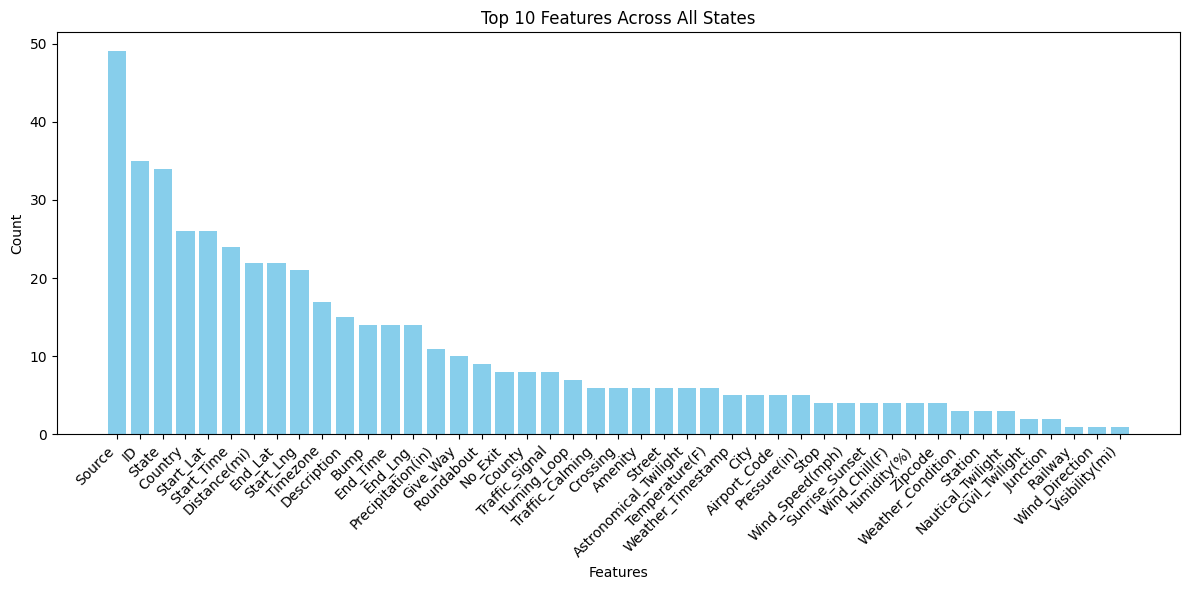

Mean score: 0.853907336354921
Average difference: 0.4719103721105378
Time elapsed: 733.7309837341309


In [8]:
"""
1. Sequential Feature Selection
"""

# Collect start time
start = time.time()

# List for storing scores
scores = []

# List for storing features selected
all_features = []

# Perform experiment over each state
for US_State_name, US_State_dataset in US_States_datasets.items():
    # Separate the features and target
    X = US_State_dataset.drop(['Severity'], axis=1)
    y = US_State_dataset['Severity']

    # Create a machine learning algorithm
    model = LogisticRegression()

    # Perform Sequential Feature Selection (SFS) on state data
    sfs = SequentialFeatureSelector(model, n_features_to_select=10, n_jobs=-1)

    # Fit using the SFS method
    sfs.fit(X, y)

    # Add to features list
    features = X.columns[sfs.support_].tolist()
    all_features.extend(features)  # Flatten features into a single list

    # Print best features for state
    print(f'{US_State_name}: {features}', end='')

    # Obtain new X
    X_new = sfs.transform(X)

    # Create and fit model for predictions using selected features
    fitted_model = MLPClassifier()

    # Perform cross validation
    score = cross_val_score(fitted_model, X_new, y, cv=3, scoring='accuracy').mean()

    # Present score for this state
    print(f' -- score: {score}')

    # Store score
    scores.append(score)

# Count the occurrence of each feature across all states
feature_counts = Counter(all_features)

# Sort features by count in descending order
sorted_features = feature_counts.most_common()

# Prepare data for plotting
features, counts = zip(*sorted_features)

# Plot the barplot
plt.figure(figsize=(12, 6))
plt.bar(features, counts, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Top 10 Features Across All States')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Present final score
print(f'Mean score: {sum(scores) / len(scores)}')

# Calculate and present feature variance 
total_difference = 0
for i in range(len(all_features)):
    for j in range(len(all_features)):
        if i != j:
            difference = SequenceMatcher(None, all_features[i], all_features[j]).ratio()
            total_difference += difference
average_difference = total_difference / ((len(all_features) * (len(all_features) - 1)) / 2)
print("Average difference:", average_difference)

# Present time elapsed
end = time.time()
print(f'Time elapsed: {end - start}')

AL: ['Start_Time', 'End_Time', 'Start_Lng', 'End_Lng', 'City', 'County', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)'] -- score: 0.9225948327741414
AR: ['Start_Time', 'End_Time', 'Start_Lng', 'End_Lng', 'Description', 'Street', 'County', 'Weather_Timestamp', 'Wind_Chill(F)', 'Humidity(%)'] -- score: 0.8582055497663972
AZ: ['Start_Time', 'End_Time', 'Description', 'Street', 'City', 'Zipcode', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)'] -- score: 0.9172023938549625
CA: ['ID', 'Start_Time', 'End_Time', 'Start_Lng', 'End_Lng', 'Description', 'Street', 'City', 'Zipcode', 'Weather_Timestamp'] -- score: 0.9780000782556574
CO: ['Start_Time', 'End_Time', 'Start_Lng', 'Street', 'City', 'Zipcode', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)'] -- score: 0.7967983834205548
CT: ['Start_Time', 'End_Time', 'Description', 'Street', 'City', 'County', 'Zipcode', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)'] -- score: 

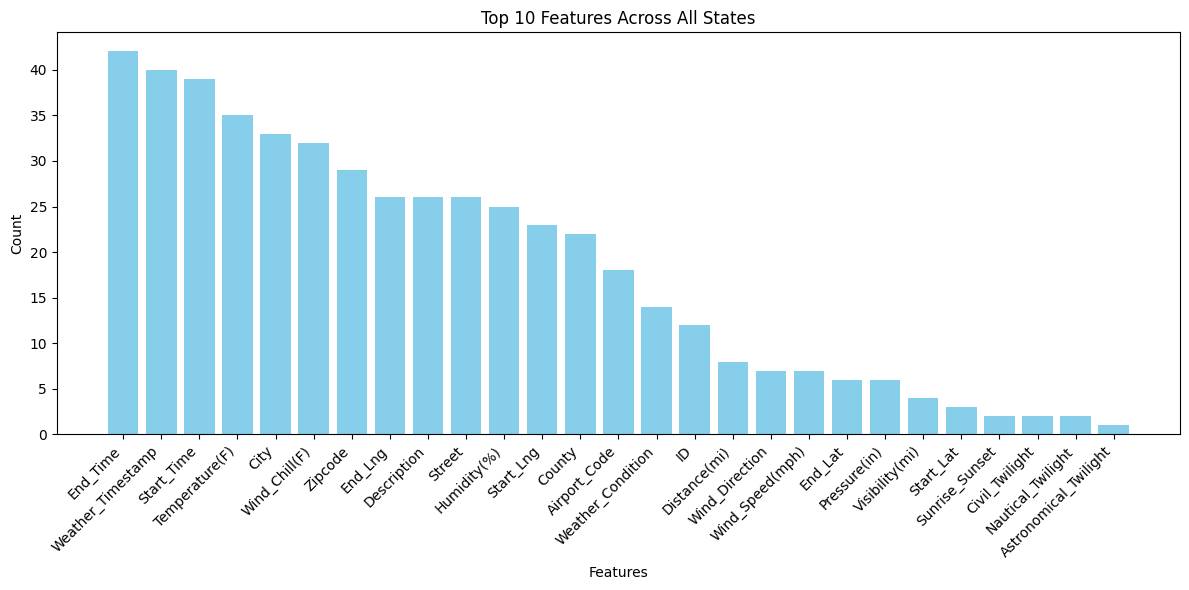

Mean score: 0.8622203205945284
Average difference: 0.523778663749354
Time elapsed: 183.27889728546143


In [10]:
"""
2. Recursive Feature Elimination
"""

# Collect start time
start = time.time()

# List for storing scores
scores = []

# List for features selected
all_features = []

# Perform experiment over each state
for US_State_name, US_State_dataset in US_States_datasets.items():

    # separate the features and target
    X = US_State_dataset.drop(['Severity'], axis=1)
    y = US_State_dataset['Severity']

    # Create a machine learning algorithm
    model = LogisticRegression()

    # Perform RFE on state data
    rfe = RFE(model, n_features_to_select=10)

    # Fit using the RFE method
    rfe.fit(X, y)

    # Add to features list
    features = X.columns[rfe.support_].tolist()
    all_features.extend(features)

    # Print best features for state
    print(f'{US_State_name}: {features}', end='')

    # Obtain new X
    X_new = rfe.transform(X)

    # Create and fit model for predictions using selected features
    fitted_model = MLPClassifier()

    # Perform cross validation
    score = cross_val_score(fitted_model, X_new, y, cv=3, scoring='accuracy').mean()

    # Present score for this state
    print(f' -- score: {score}')

    # Store score
    scores.append(score)

# Count the occurrence of each feature across all states
feature_counts = Counter(all_features)

# Sort features by count in descending order
sorted_features = feature_counts.most_common()

# Prepare data for plotting
features, counts = zip(*sorted_features)

# Plot the barplot
plt.figure(figsize=(12, 6))
plt.bar(features, counts, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Top 10 Features Across All States')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Present final score
print(f'Mean score: {sum(scores) / len(scores)}')

# Calculate and present feature variance 
total_difference = 0
for i in range(len(all_features)):
    for j in range(len(all_features)):
        if i != j:
            difference = SequenceMatcher(None, all_features[i], all_features[j]).ratio()
            total_difference += difference
average_difference = total_difference / ((len(all_features) * (len(all_features) - 1)) / 2)
print("Average difference:", average_difference)

# Present time elapsed
end = time.time()
print(f'Time elapsed: {end - start}')

AL: ['ID', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street'] -- score: 0.9117945918619398
AR: ['ID', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street'] -- score: 0.8539936670529039
AZ: ['ID', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street'] -- score: 0.9160045541912026
CA: ['ID', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street'] -- score: 0.9642023576077102
CO: ['ID', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street'] -- score: 0.7616062621809373
CT: ['ID', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street'] -- score: 0.8936007516383878
DC: ['ID', 'Start_Time', 'End_Time', 'Distance(mi)', 'Description', 'S

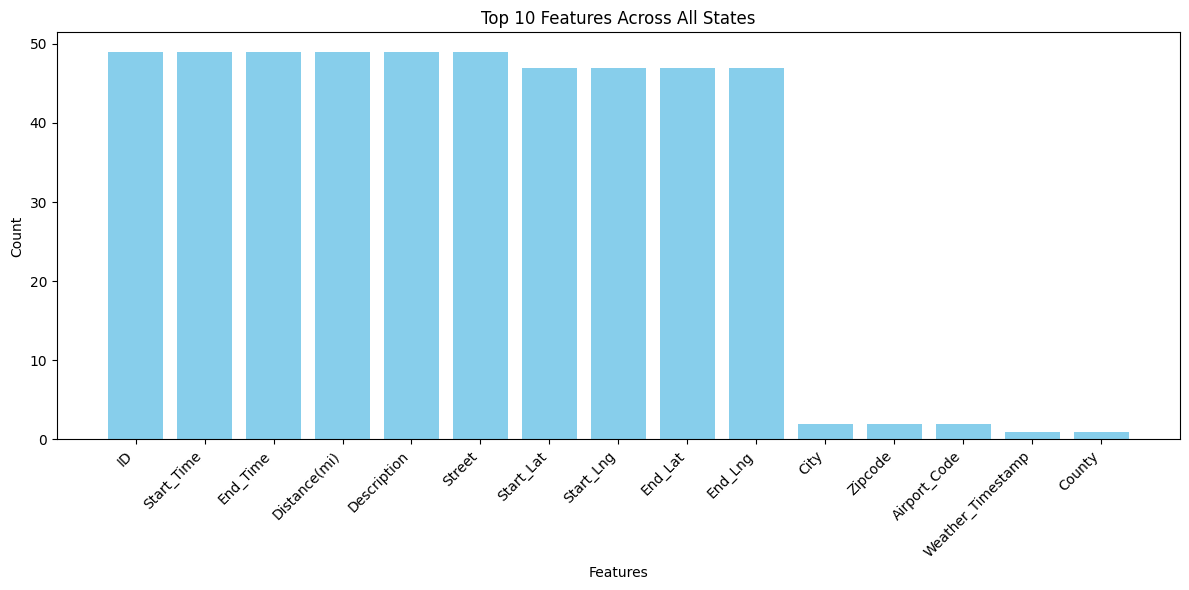

Mean score: 0.8247471254689277
Average difference: 0.6336368105425312
	Time elapsed: 29.625702142715454


In [11]:
"""
3. Variance Thresholding
"""

# Collect start time
start = time.time()

# List for storing scores
scores = []

# List for storing features selected
all_features = []

# Perform experiment over each state
for US_State_name, US_State_dataset in US_States_datasets.items():

    # separate the features and target
    X = US_State_dataset.drop(['Severity'], axis=1)
    y = US_State_dataset['Severity']

    # Perform variance threshold on X
    var = VarianceThreshold(0.01)

    # Create new X with variance threshold applied
    X_new = var.fit_transform(X)

    # Find the 10 best features
    top10 = var.get_support(indices=True)[:10]

    # Add to features list
    features = X.columns[top10].to_list()
    all_features.extend(features)

    # Present 10 best features
    print(f'{US_State_name}: {features}', end='')

    # Create and fit model for predictions using selected features
    fitted_model = MLPClassifier()

    # Perform cross validation
    score = cross_val_score(fitted_model, X_new, y, cv=3, scoring='accuracy').mean()

    # Present score for this state
    print(f' -- score: {score}')

    # Store score
    scores.append(score)

# Count the occurrence of each feature across all states
feature_counts = Counter(all_features)

# Sort features by count in descending order
sorted_features = feature_counts.most_common()

# Prepare data for plotting
features, counts = zip(*sorted_features)

# Plot the barplot
plt.figure(figsize=(12, 6))
plt.bar(features, counts, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Top 10 Features Across All States')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Present final score
print(f'Mean score: {sum(scores) / len(scores)}')

# Calculate and present feature variance 
total_difference = 0
for i in range(len(all_features)):
    for j in range(len(all_features)):
        if i != j:
            difference = SequenceMatcher(None, all_features[i], all_features[j]).ratio()
            total_difference += difference
average_difference = total_difference / ((len(all_features) * (len(all_features) - 1)) / 2)
print("Average difference:", average_difference)

# Present time elapsed
end = time.time()
print(f'\tTime elapsed: {end - start}')

AL: ['Description', 'ID', 'End_Time', 'Start_Time', 'Weather_Timestamp', 'End_Lng', 'Start_Lng', 'Distance(mi)', 'End_Lat', 'Start_Lat'] -- score: 0.9083992325184423
AR: ['Description', 'ID', 'Street', 'End_Time', 'Distance(mi)', 'Start_Time', 'End_Lat', 'Start_Lat', 'Zipcode', 'Weather_Timestamp'] -- score: 0.872801310086122
AZ: ['Distance(mi)', 'Description', 'Weather_Timestamp', 'Start_Time', 'End_Time', 'ID', 'Traffic_Signal', 'Crossing', 'Start_Lat', 'End_Lat'] -- score: 0.9252017543670137
CA: ['Start_Time', 'Weather_Timestamp', 'End_Time', 'ID', 'Description', 'Start_Lng', 'Distance(mi)', 'End_Lng', 'End_Lat', 'Start_Lat'] -- score: 0.9706008378156302
CO: ['ID', 'End_Time', 'Description', 'Start_Time', 'Weather_Timestamp', 'Distance(mi)', 'Street', 'End_Lng', 'Start_Lng', 'Start_Lat'] -- score: 0.7455927782030628
CT: ['Description', 'End_Time', 'ID', 'Start_Time', 'Weather_Timestamp', 'Street', 'Distance(mi)', 'End_Lng', 'Start_Lng', 'End_Lat'] -- score: 0.9103973923102534
DC: ['

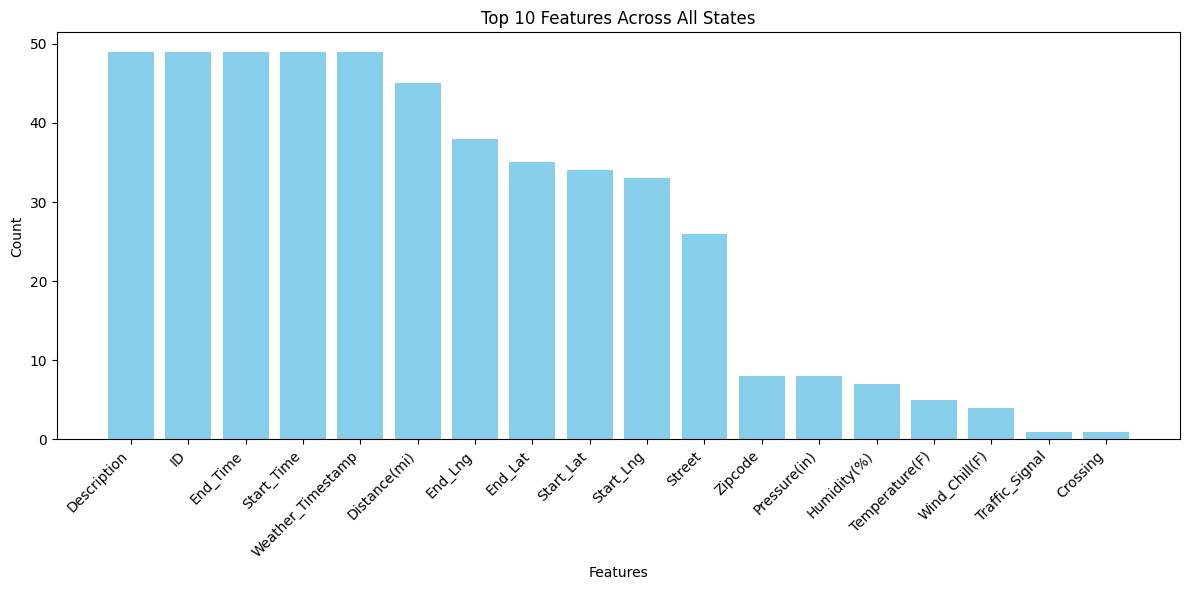

Mean score: 0.8326413023104312
Average difference: 0.575629705388558
Time elapsed: 256.25128507614136


In [12]:
"""
4. Random Forest-based Feature Selection
"""

# Collect start time
start = time.time()

# List for storing scores
scores = []

# List for features selected
all_features = []

# Perform experiment over each state
for US_State_name, US_State_dataset in US_States_datasets.items():

    # separate the features and target
    X = US_State_dataset.drop(['Severity'], axis=1)
    y = US_State_dataset['Severity']

    # Create random forest classifier
    rfc = RandomForestClassifier(n_estimators=500, random_state=42)

    # Fit random forest classifier to data
    rfc.fit(X, y)

    # Find the 10 best features
    top10 = pd.Series(rfc.feature_importances_, index=X.columns)

    # Sort the 10 best features by score (descending)
    top10sorted = top10.sort_values(ascending=False)

    # Add to features list
    features = top10sorted.index[:10].to_list()
    all_features.extend(features)

    # Present the top 10 features
    print(f'{US_State_name}: {features}', end='')

    # Create a new X containing only the selected features
    X_new = X[top10sorted.index.tolist()]

    # Create and fit model for predictions using selected features
    fitted_model = MLPClassifier()

    # Perform cross validation
    score = cross_val_score(fitted_model, X_new, y, cv=3, scoring='accuracy').mean()

    # Present score for this state
    print(f' -- score: {score}')

    # Store score
    scores.append(score)

# Count the occurrence of each feature across all states
feature_counts = Counter(all_features)

# Sort features by count in descending order
sorted_features = feature_counts.most_common()

# Prepare data for plotting
features, counts = zip(*sorted_features)

# Plot the barplot
plt.figure(figsize=(12, 6))
plt.bar(features, counts, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Top 10 Features Across All States')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Present final score
print(f'Mean score: {sum(scores) / len(scores)}')

# Calculate and present feature variance 
total_difference = 0
for i in range(len(all_features)):
    for j in range(len(all_features)):
        if i != j:
            difference = SequenceMatcher(None, all_features[i], all_features[j]).ratio()
            total_difference += difference
average_difference = total_difference / ((len(all_features) * (len(all_features) - 1)) / 2)
print("Average difference:", average_difference)

# Present time elapsed
end = time.time()
print(f'Time elapsed: {end - start}')

AL: ['Weather_Timestamp', 'End_Time', 'Start_Time', 'ID', 'Description', 'Humidity(%)', 'Wind_Chill(F)', 'City', 'Zipcode', 'Airport_Code'] -- score: 0.8846014710623301
AR: ['Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 'ID', 'Street', 'Humidity(%)', 'Zipcode', 'Visibility(mi)', 'Wind_Chill(F)'] -- score: 0.8245904240520444
AZ: ['End_Time', 'Weather_Timestamp', 'Start_Time', 'ID', 'Description', 'Zipcode', 'City', 'Humidity(%)', 'Street', 'County'] -- score: 0.9293985140546921
CA: ['ID', 'Description', 'Street', 'Zipcode', 'City', 'Traffic_Signal', 'Traffic_Calming', 'Stop', 'Astronomical_Twilight', 'Nautical_Twilight'] -- score: 0.9807998784396782
CO: ['Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 'ID', 'Street', 'Humidity(%)', 'City', 'Traffic_Signal', 'Crossing'] -- score: 0.754800060396084
CT: ['End_Time', 'Weather_Timestamp', 'Start_Time', 'ID', 'Description', 'Street', 'Zipcode', 'Wind_Chill(F)', 'County', 'Weather_Condition'] -- score: 0.864997228

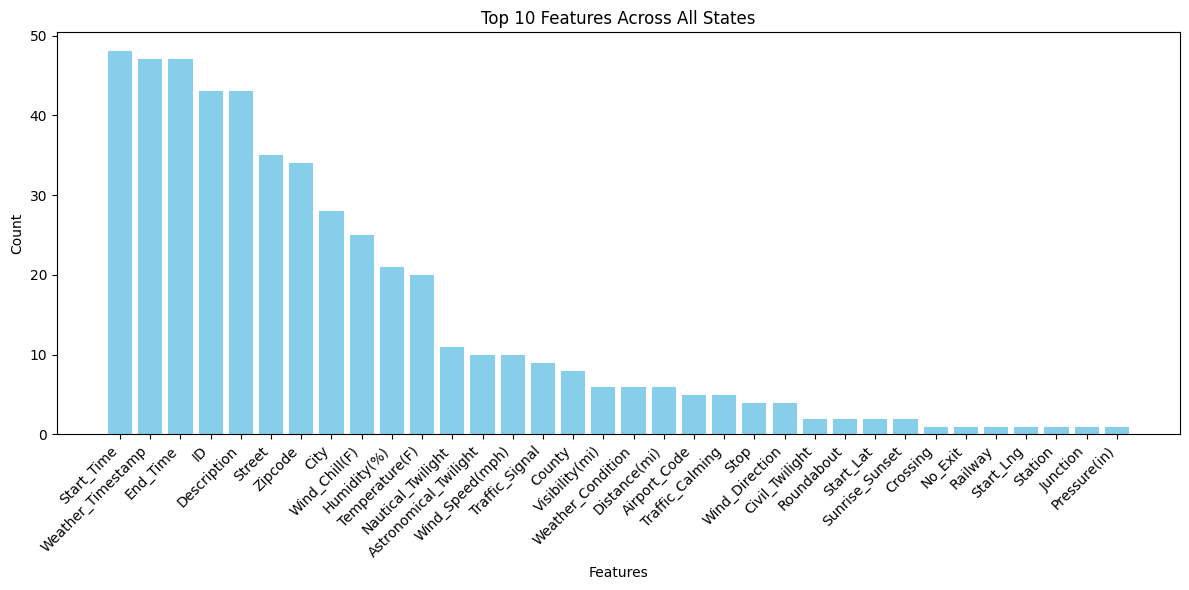

Mean score: 0.8363172396099973
Average difference: 0.4995674306578171
Time elapsed: 142.22639632225037


In [13]:
"""
5. Neural Network-based Feature Selection
"""

# Collect start time
start = time.time()

# List for storing scores
scores = []

# List for features selected
all_features = []

# Perform experiment over each state
for US_State_name, US_State_dataset in US_States_datasets.items():

    # separate the features and target
    X = US_State_dataset.drop(['Severity'], axis=1)
    y = US_State_dataset['Severity']

    # Create MLP Classifier
    mlpc = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)

    # Fit MLP Classifier to data
    mlpc.fit(X, y)

    # use permutation feature importance to rank the features
    top10 = permutation_importance(mlpc, X, y, n_repeats=10)

    # sort the feature importance scores in descending order
    top10sorted = top10.importances_mean.argsort()[::-1]

    # Add to features list
    features = [X.columns[top10sorted[i]] for i in range(10)]
    all_features.extend(features)

    # Present the top 10 features
    print(f'{US_State_name}: {features}', end='')

    # Get the list of feature names from top10sorted
    feature_names = X.columns[top10sorted].tolist()

    # Create a new X containing only the selected features
    X_new = X[feature_names]

    # Create and fit model for predictions using selected features
    fitted_model = MLPClassifier()

    # Perform cross validation
    score = cross_val_score(fitted_model, X_new, y, cv=3, scoring='accuracy').mean()

    # Present score for this state
    print(f' -- score: {score}')

    # Store score
    scores.append(score)

# Count the occurrence of each feature across all states
feature_counts = Counter(all_features)

# Sort features by count in descending order
sorted_features = feature_counts.most_common()

# Prepare data for plotting
features, counts = zip(*sorted_features)

# Plot the barplot
plt.figure(figsize=(12, 6))
plt.bar(features, counts, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Top 10 Features Across All States')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Present final score
print(f'Mean score: {sum(scores) / len(scores)}')

# Calculate and present feature variance 
total_difference = 0
for i in range(len(all_features)):
    for j in range(len(all_features)):
        if i != j:
            difference = SequenceMatcher(None, all_features[i], all_features[j]).ratio()
            total_difference += difference
average_difference = total_difference / ((len(all_features) * (len(all_features) - 1)) / 2)
print("Average difference:", average_difference)

# Present time elapsed
end = time.time()
print(f'Time elapsed: {end - start}')